In [151]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm


In [152]:
#Datasets that were gonna be used (capita income and population density datasets werent used due to time constraints)
capita_income=pd.read_csv('./per_capita_income_USA.csv')
population_density=pd.read_csv('./population_density_USA.csv')
GMSL=pd.read_csv('./GMSL.csv')
#merged dataset
merged_df=capita_income.merge(population_density,on="Year").merge(GMSL,on="Year")
print(merged_df.to_string())


    Year  per capita income  Population density   GMSL      SLR
0   1992              21090               25.95 -30.117   1.400
1   1993              21733               26.32 -31.351  -1.234
2   1994              22575               26.68 -29.127   2.224
3   1995              23607               27.02 -21.035   8.092
4   1996              24771               27.36 -21.681  -0.646
5   1997              25993               27.71 -24.456  -2.775
6   1998              27557               28.06 -15.194   9.262
7   1999              28693               28.40 -21.872  -6.678
8   2000              30672               28.72 -13.015   8.857
9   2001              31617               29.04  -8.530   4.485
10  2002              31839               29.33  -5.172   3.358
11  2003              32717               29.61  -1.323   3.849
12  2004              34280               29.90   0.968   2.291
13  2005              35868               30.19   6.829   5.861
14  2006              38120             

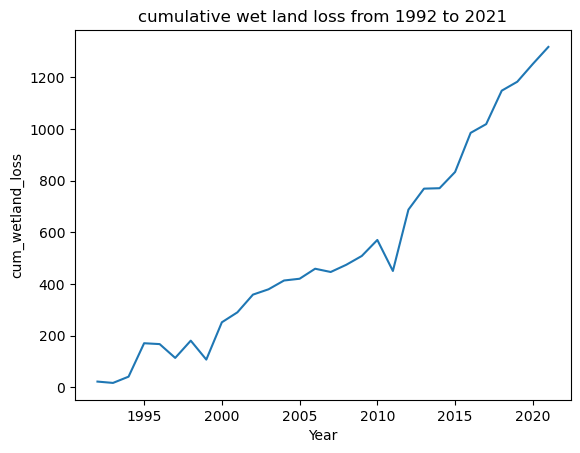

--------------------------------


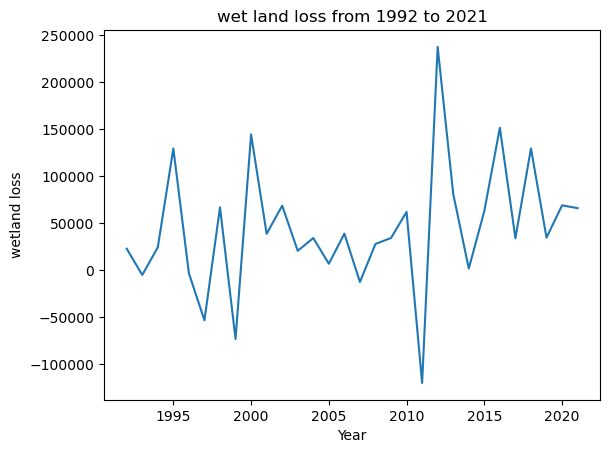

-------------------
    Year  per capita income  Population density   GMSL      SLR  cum_wetland_loss   wetland loss
0   1992              21090               25.95 -30.117   1.400         22.772792   22772.791939
1   1993              21733               26.32 -31.351  -1.234         17.598876   -5173.916058
2   1994              22575               26.68 -29.127   2.224         41.794217   24195.340668
3   1995              23607               27.02 -21.035   8.092        171.041994  129247.777056
4   1996              24771               27.36 -21.681  -0.646        167.687239   -3354.754191
5   1997              25993               27.71 -24.456  -2.775        114.309760  -53377.478928
6   1998              27557               28.06 -15.194   9.262        181.012737   66702.976840
7   1999              28693               28.40 -21.872  -6.678        107.792828  -73219.909429
8   2000              30672               28.72 -13.015   8.857        251.991037  144198.208852
9   2001  

In [159]:

#protection fraction for wetland coast (US coastline protection from hard structures)
coast_prot=0.14
#1990 wetlandcoast for USA for milimeters (http://www.fund-model.org/MimiFUND.jl/latest/tables/#Table-SLR:-Impact-of-sea-level-rise-1)
wetlandmax=42828800
#dictionaries to carry wetland lost and cumulative wetland loss
wetlandloss={}
cum_wetland_loss={}
cum_wetland_loss[1991]=0.0#no wetland loss assumption (couldnt get GMSL for earlier than 1992)

def wetland_loss(slr,year):
    #annual wetland loss due to coastal squeeze (normal distribution that is truncated )
    annual_wetloss_coastal_squeeze=truncnorm((0.0-789)/8344,np.inf,loc=789,scale=8344)
    annual_wetloss_coastal_squeeze_sample=((annual_wetloss_coastal_squeeze.rvs())*1000)#random var form distribution and scaled by 1000 to account for meters to milimeters (GMSL dataset is in mm)
    #annual wetland loss due to sea level rise (normal distribution that is truncated )
    annual_wet_loss_slr=truncnorm((0.0-11400)/5700,np.inf,loc=11400,scale=5700)
    annual_wet_loss_slr_sample=((annual_wet_loss_slr.rvs())*1000)#random var form distribution and scaled by 1000 to account for meters to milimeters (GMSL dataset is in mm)
    wetloss_eqn=(annual_wet_loss_slr_sample*slr+annual_wetloss_coastal_squeeze_sample*coast_prot*slr)/1000#divided by 1000 so that we can go back to meters
    #wetland lost per year
    wetlandloss[year]=min(wetloss_eqn,(wetlandmax-cum_wetland_loss[year-1]))
    #cumulative wetland lost
    cum_wetland_loss[year]=cum_wetland_loss[year-1]+wetlandloss[year]/1000#divided by 1000 so that we can go back to meters
    return cum_wetland_loss[year],wetlandloss[year]
merged_df['cum_wetland_loss'],merged_df["wetland loss"]=zip(*merged_df.apply(lambda row:wetland_loss(row['SLR'],row['Year']),axis=1))
# Plot the output for each row for cumulative wetland loss
plt.plot(merged_df['Year'], merged_df['cum_wetland_loss'])
plt.xlabel('Year')
plt.ylabel('cum_wetland_loss')
plt.title("cumulative wet land loss from 1992 to 2021")
plt.show()
print('--------------------------------')
# Plot the output for each row for wetland loss
plt.plot(merged_df["Year"],merged_df['wetland loss'])
plt.xlabel('Year')
plt.ylabel('wetland loss')
plt.title("wet land loss from 1992 to 2021")
plt.show()
print('-------------------')
#new dataframe that can be useful for future calculations (if we had more time we wouldve used this to calculate value of wetland loss)
print(merged_df.to_string())
